In [1]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import utils.configuration as cf
import utils.datasets as ud
from models.mnist_conv import mnist_conv
from scipy.interpolate import make_interp_spline
from custom_regularizers import DynamicRankNuclearRegularizer

# Fix the random seed

In [2]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [3]:
conf_args = {#
    # data specification
    'data_file':"../../datasets",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':2, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':50,
    # optimizer
    'delta':20.0, 'lr':0.01, 'lamda_0':1e-4, 'lamda_1':0.008, 'optim':"LinBreg", 'conv_group':True,
    'beta':0.9,
    # initialization
    'sparse_init':0.01, 'r':[10.,10.,10.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)
best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

# Weight initialization

In [5]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Linear)
    model = model.to(conf.device)    
    return model

model = init_weights(conf,model)

# Optimizer

In [6]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    
    # Separate first FCC layer from other linear layers
    first_fcc = [model.layers2[0].weight]  # First FCC layer (1024→128)
    other_linear = [p for n, p in model.named_parameters() 
                   if isinstance(p, torch.nn.Parameter) and 'weight' in n 
                   and n != 'layers2.0.weight' and 'layers2' in n]
    
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg": # change 'reg' to reg2 if want to use l1_l2 regularization as was previously
        opt = op.LinBreg([
            {'params': weights_conv, 'lr': conf.lr, 'reg': reg2, 'momentum': conf.beta, 'delta': conf.delta},
            # Apply nuclear norm regularization ONLY to first FCC layer
            {'params': first_fcc, 'lr': conf.lr, 'reg': DynamicRankNuclearRegularizer(lamda=conf.lamda_1, initial_rank=16, max_rank=96), 'momentum': conf.beta, 'delta': conf.delta},
            # Apply L1 regularization to other linear layers
            {'params': other_linear, 'lr': conf.lr, 'reg': reg.reg_l1(lamda=conf.lamda_0), 'momentum': conf.beta, 'delta': conf.delta},
            {'params': biases, 'lr': conf.lr, 'momentum': conf.beta}
        ])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_linear(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_conv(lamda=conf.lamda_0),'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

# Dataset

In [7]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# History and Runs

In [8]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {}
val_hist = {}

# Training

In [9]:
# -----------------------------------------------------------------------------------
# Reinit weights and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model) # scheduler is for LR

# <<< Instantiate the NuclearLambdaScheduler >>>
# Monitor validation loss (mode='min'). Apply to group 1 (weights_linear).
# Adjust patience, factor, min_lambda as needed.
nuclear_scheduler = op.NuclearLambdaScheduler(
    optimizer=opt,
    group_idx=1,      # Index of the linear weights group
    patience=2,       # Epochs to wait for improvement before reducing lambda
    factor=0.5,       # Multiplicative factor for lambda reduction
    min_lambda=0.1,  # Minimum lambda value
    mode='min',       # Reduce lambda when validation 'loss' stops decreasing
    verbose=True
)

rank_scheduler = op.RankScheduler(
    optimizer=opt,
    group_idx=1,      # Same group as lambda scheduler
    patience=3,       # Wait 3 epochs before increasing rank 
    increase_by=16,   # Increase rank by 16 each time
    steps_until_max=5,# Do at most 5 increases (to 16+16*5 = 96)
    mode='min',       # Triggered when validation loss plateaus
    verbose=True      # Print when rank increases
)

# Initialize history for tracking metrics
effective_rank_histories = {}  # Dictionary to store rank history for each layer
test_accuracy_history = []
nuclear_lambda_history = [] # <<< Store lambda history >>>
rank_history = []  # Initialize rank history list

# Initialize timer variables
epoch_total_times = [] # List to store total time for each epoch
overall_start_time = time.time() # Start timer for all epochs

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    epoch_start_time = time.time() # Start epoch timer
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update train history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])

    # ------------------------------------------------------------------------
    # validation step
    # ------------------------------------------------------------------------
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)

    # <<< Step the nuclear lambda scheduler using validation loss >>>
    val_loss = val_data['loss'] # Or use val_data['acc'] and mode='max'
    nuclear_scheduler.step(val_loss)
    rank_scheduler.step(val_loss)


    # <<< Store current nuclear norm lambda >>>
    current_nuclear_lambda = opt.param_groups[1]['reg'].lamda
    nuclear_lambda_history.append(current_nuclear_lambda)
    print(f"  Current Nuclear Norm Lambda (Group 1): {current_nuclear_lambda:.2e}")
    # Track the current rank constraint
    if epoch == 0:
        rank_history = []  # Initialize only once at the start of training
    current_rank = opt.param_groups[1]['reg'].get_rank()
    rank_history.append(current_rank)

    # Track effective rank ratio for each FC layer separately
    # Use a consistent epsilon, e.g., 1e-6
    fc_layer_ranks = maf.get_linear_layer_ranks(model, epsilon=1e-4)
    for layer_name, rank_ratio in fc_layer_ranks.items():
        if layer_name not in effective_rank_histories:
            effective_rank_histories[layer_name] = []
        effective_rank_histories[layer_name].append(rank_ratio)
        print(f'  Layer {layer_name} rank ratio (ε=1e-6): {rank_ratio:.4f}')

    # Also track test accuracy each epoch
    test_data = train.test(conf, model, test_loader, verbosity=0)
    test_accuracy_history.append(test_data['acc'])
    print(f'  Test Accuracy: {test_data["acc"]:.4f}')

    # Step the learning rate scheduler based on train loss
    scheduler.step(train_data['loss'])
    print(f"  Learning rate: {opt.param_groups[0]['lr']}") # Print LR for group 0
    best_model(train_data['acc'], val_data['acc'], model=model)

    epoch_end_time = time.time() # End epoch timer
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_total_times.append(epoch_duration) # Store total epoch duration
    print(f"Epoch {epoch} total time: {epoch_duration:.2f} seconds") # Print total epoch time


overall_end_time = time.time() # End timer for all epochs
total_training_time = overall_end_time - overall_start_time # Calculate total time directly

# Print final timing information
print("\n" + 50*"-")
if epoch_total_times: # Avoid division by zero if epochs=0
    avg_epoch_time = sum(epoch_total_times) / len(epoch_total_times)
    print(f"Average Total Epoch Time: {avg_epoch_time:.2f} seconds")
print(f"Total Training Time ({conf.epochs} epochs): {total_training_time:.2f} seconds")
print(50*"-")

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0
--------------------------------------------------
Train Accuracy: 0.5021754385964913
Train Loss: 641.8954088687897
--------------------------------------------------
Validation Accuracy: 0.633
Non-zero kernels: 0.7245192307692307
Linear sparsity: 0.9659846470019342
Overall sparsity: 0.859734633089629
Node sparsity: [1.0, 1.0]
Regularization values per group: [0.22768875789642334, tensor(0.7504), 0.030365252685546875, 0.0]
  Current Nuclear Norm Lambda (Group 1): 8.00e-03
  Layer layers2.0 rank ratio (ε=1e-6): 0.1250
  Layer layers2.2 rank ratio (ε=1e-6): 1.0000
  Test Accuracy: 0.6426
  Learning rate: 0.01
Epoch 0 total time: 25.46 seconds
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
---------------------------

# Evaluation

In [10]:
train.test(conf, best_model.best_model, test_loader) 
print(f'Convolution kernel sparsity: {maf.conv_sparsity(best_model.best_model)}')
print(f'Linear sparsity: {maf.linear_sparsity(best_model.best_model)}')
linear_rank_ratio = maf.linear_effective_rank_ratio(best_model.best_model, epsilon=1e-4)
print(f'Linear Layer Effective Rank Ratio (ε=1e-3): {linear_rank_ratio}')
fc_layer_ranks = maf.get_linear_layer_ranks(best_model.best_model, epsilon=1e-4)
for layer_name, rank_ratio in fc_layer_ranks.items():
    print(f'Layer {layer_name} rank ratio (ε=1e-3): {fc_layer_ranks[layer_name]}')
print("\nSingular values of linear layers:")
for name, m in best_model.best_model.named_modules():
    if isinstance(m, torch.nn.Linear):
        _, S, _ = torch.svd(m.weight, some=True)
        print(f"Layer {name} singular values: {S[:10]}")  # Show first 10 values

--------------------------------------------------
Test Accuracy: 0.8551
Convolution kernel sparsity: 0.8502403846153846
Linear sparsity: 0.9941217359767892
Linear Layer Effective Rank Ratio (ε=1e-3): 0.875
Layer layers2.0 rank ratio (ε=1e-3): 0.75
Layer layers2.2 rank ratio (ε=1e-3): 1.0

Singular values of linear layers:
Layer layers2.0 singular values: tensor([30.9755, 14.9485,  8.2377,  7.9961,  5.0443,  4.9935,  4.7671,  4.5938,
         4.4152,  4.0559], grad_fn=<SliceBackward0>)
Layer layers2.2 singular values: tensor([13.6836, 10.1569,  5.3384,  3.2963,  2.9478,  2.1406,  1.3975,  1.2466,
         1.1025,  0.7041], grad_fn=<SliceBackward0>)


# Setup plots and appearance

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

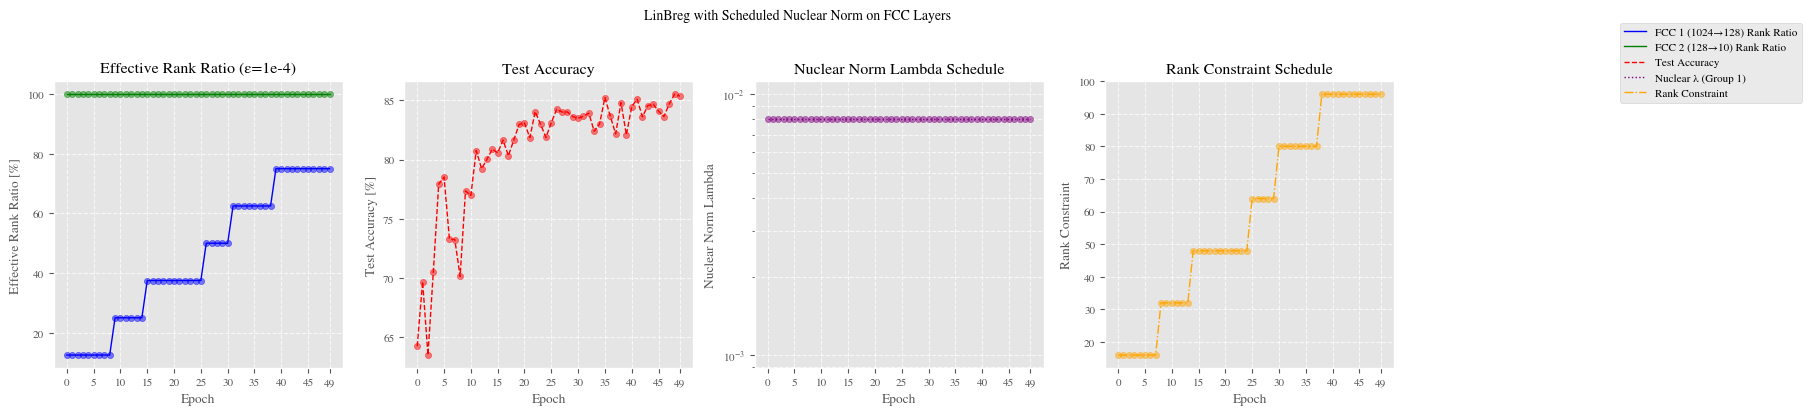

In [12]:
# Cell 18 (plotting cell)

# Create a figure with 1x4 subplots (rank ratio, accuracy, lambda, rank)
fig, ax = plt.subplots(1, 4, figsize=(16, 4)) # Adjusted figsize
ax = np.ravel(ax)  # Convert to 1D array for consistent indexing

# Create arrays for plotting
x = np.array(range(conf.epochs))

# Dictionary to map layer names to more descriptive labels
layer_display_names = {
    'layers2.0': 'FCC 1 (1024→128)',  # First fully connected layer
    'layers2.2': 'FCC 2 (128→10)'     # Second fully connected layer
}

# --- Subplot 0: Effective Rank Ratio ---
colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink']
handles0, labels0 = [], []
for i, (layer_name, history) in enumerate(effective_rank_histories.items()):
    color = colors[i % len(colors)]
    display_name = layer_display_names.get(layer_name, layer_name)
    history_percent = [val * 100 for val in history]
    line, = ax[0].plot(x, history_percent, linestyle='-', color=color, label=f'{display_name} Rank Ratio')
    ax[0].scatter(x, history_percent, color=color, s=20, alpha=0.5)
    handles0.append(line)
    labels0.append(f'{display_name} Rank Ratio')

ax[0].set_ylabel('Effective Rank Ratio [%]')
ax[0].set_xlabel('Epoch')
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].set_title('Effective Rank Ratio (ε=1e-4)')

# --- Subplot 1: Test Accuracy ---
test_accuracy_percent = [acc * 100 for acc in test_accuracy_history]
line_acc, = ax[1].plot(x, test_accuracy_percent, linestyle='--', color='red', label='Test Accuracy')
ax[1].scatter(x, test_accuracy_percent, color='red', s=20, alpha=0.5)
ax[1].set_ylabel('Test Accuracy [%]')
ax[1].set_xlabel('Epoch')
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].set_title('Test Accuracy')
handles1, labels1 = [line_acc], ['Test Accuracy']

# --- Subplot 2: Nuclear Norm Lambda ---
line_lambda, = ax[2].plot(x, nuclear_lambda_history, linestyle=':', color='purple', label='Nuclear λ (Group 1)')
ax[2].scatter(x, nuclear_lambda_history, color='purple', s=20, alpha=0.5)
ax[2].set_ylabel('Nuclear Norm Lambda')
ax[2].set_xlabel('Epoch')
ax[2].set_yscale('log') # Use log scale for lambda
ax[2].grid(True, which="both", linestyle='--', alpha=0.7) # Grid for log scale
ax[2].set_title('Nuclear Norm Lambda Schedule')
handles2, labels2 = [line_lambda], ['Nuclear λ (Group 1)']

# --- Subplot 3: Rank Constraint ---
line_rank, = ax[3].plot(x, rank_history, linestyle='-.', color='orange', label='Rank Constraint')
ax[3].scatter(x, rank_history, color='orange', s=20, alpha=0.5)
ax[3].set_ylabel('Rank Constraint')
ax[3].set_xlabel('Epoch')
ax[3].grid(True, linestyle='--', alpha=0.7)
ax[3].set_title('Rank Constraint Schedule')
handles3, labels3 = [line_rank], ['Rank Constraint']

# First define xticks
max_epoch = len(x) - 1
xticks = [i for i in range(0, max_epoch+1, 5)]
if max_epoch not in xticks:
    xticks.append(max_epoch)

# Then apply to all 4 subplots
for i in range(4):
    ax[i].set_xticks(xticks)

# Combine all handles and labels including the rank constraint
all_handles = handles0 + handles1 + handles2 + handles3
all_labels = labels0 + labels1 + labels2 + labels3

# Create legend with all plots
fig.legend(all_handles, all_labels, loc='upper left', bbox_to_anchor=(1.01, 1), prop={'size': 8}, ncol=1)

# Adjust size and title
fig.suptitle('LinBreg with Scheduled Nuclear Norm on FCC Layers', fontsize=10, y=1.02)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.88, 0.98])  # Adjust right margin for legend

plt.show()